In [1272]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing #used for encoding of categorical variables
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

file_list = []
for dirname, _, filenames in os.walk(r'C:\Users\f93495c\Downloads\titanic'):
    for filename in filenames:
        file_list.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1231]:
file_list

['C:\\Users\\f93495c\\Downloads\\titanic\\test.csv',
 'C:\\Users\\f93495c\\Downloads\\titanic\\train.csv']

In [1232]:
train_data = pd.read_csv(file_list[1])
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1233]:
test_data = pd.read_csv(file_list[0])
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [1234]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [1235]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


# Feature Engeneering 

**Checking Na values**

In [1236]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [1237]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

**Classes of Fare by Range of Fare paid**

In [1238]:
le = preprocessing.LabelEncoder()
train_data['Fare_range'] = le.fit_transform(pd.cut(train_data['Fare'].astype(float), 20)) 

In [1239]:
avg_fare = round(test_data.dropna(subset = ['Fare']).mean()['Fare'],2)
print('the average fare paid is {} dollars.'.format(avg_fare))
print('this value will be used to fill the na values in the test set.')

the average fare paid is 35.63 dollars.
this value will be used to fill the na values in the test set.


In [1240]:
test_data['Fare'] = np.where(test_data['Fare'].isna(), avg_fare,test_data['Fare'])

In [1241]:
test_data['Fare_range'] = le.fit_transform(pd.cut(test_data['Fare'].astype(float), 10))

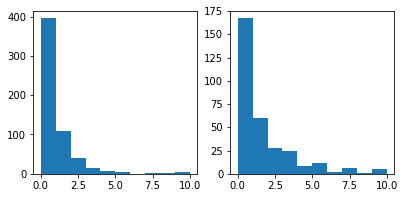

In [1242]:
male_fare = train_data.loc[train_data['Sex'] == 'male']['Fare_range']
female_fare = train_data.loc[train_data['Sex'] == 'female']['Fare_range']
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.hist(male_fare)
plt.subplot(132)
plt.hist(female_fare)
plt.show()

**Fill Na for AGE with the Mean**

In [1243]:
print('Age is missing for {} passengers'.format(len(list(np.where(train_data['Age'].isna())[0]))))

Age is missing for 177 passengers


In [1244]:
average_age = round(train_data['Age'].dropna().mean(),0)
print('The average age of the training sample is {}.'.format(int(average_age)))

The average age of the training sample is 30.


In [1245]:
train_data['Age'] = train_data['Age'].fillna(average_age)
test_data['Age'] = test_data['Age'].fillna(average_age)

**Determine a new feature "Title"**

In [1246]:
train_titles = train_data['Name'].astype(str).str.findall('(?:\S*\.)')
test_titles = test_data['Name'].astype(str).str.findall('(?:\S*\.)')

def unique_titles(titles):
    formatted_titles = []
    for i in titles:
        title = i[0] 
        if title not in formatted_titles:
            formatted_titles.append(title)
    return formatted_titles

title_groups = unique_titles(train_titles)
test_title_groups = unique_titles(test_titles)
test_title_groups

['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Ms.', 'Col.', 'Rev.', 'Dr.', 'Dona.']

In [1247]:
def titles(df):
    listoftitles = df['Name'].astype(str).str.findall('(?:\S*\.)')
    return listoftitles

def formatted_titles(df):
    listoftitles = titles(df)
    formatted_titles = []
    for i in listoftitles:
        title = i[0] 
        if title == 'Dona.':
            title = 'Don.'
        formatted_titles.append(title)
    df['Title_name'] = formatted_titles
    return df

def df_encoded_titles(df):
    le = preprocessing.LabelEncoder()
    df = formatted_titles(df)
    df['Title_Class'] = le.fit_transform(df['Title_name'])
    return df

def title_ranges_encoder(df):
    titledf = pd.DataFrame()
    titledf['Title_Class'] = pd.cut(df.groupby(by = 'Title_name').mean()['Pclass'],3)
    titledf['Title_Class'] = le.fit_transform(titledf['Title_Class'])
    return titledf.reset_index()

def title_groups(df):
    df = formatted_titles(df)
    title_range = title_ranges_encoder(df)
    newdf = pd.merge(df, title_range, on = 'Title_name', how = 'left')
    return newdf

In [1248]:
train_data = df_encoded_titles(train_data)
test_data = df_encoded_titles(test_data)

**Determine a new feature "N.Relatives"**

In [1249]:
def tot_relatives(col1, col2):
    relatives = col1 + col2
    return relatives

train_data['N.Relatives'] = tot_relatives(train_data['SibSp'],train_data['Parch'])
test_data['N.Relatives'] = tot_relatives(test_data['SibSp'],test_data['Parch'])

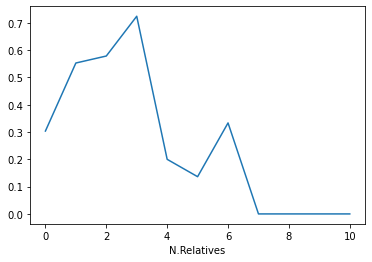

In [1250]:
train_data.groupby(by='N.Relatives').mean()['Survived'].plot()

**Fill Na in Embarked (google says both na are = S)**

In [1251]:
train_data['Embarked'] = train_data['Embarked'].fillna('S')

**Determine a new feature "Company", based on the number of passengers with the same Ticket number**

In [1252]:
def company(df):
    ticket_company = df.groupby(by='Ticket').count().sort_values(by = 'PassengerId', ascending = False)['PassengerId'].reset_index().rename(columns = {'PassengerId': 'Company' })
    return ticket_company

def create_company_column(df):
    company_df = company(df)
    merged_df = pd.merge(df, company_df, on = 'Ticket', how = 'left')
    return merged_df

In [1253]:
train_data = create_company_column(train_data)
test_data = create_company_column(test_data)

In [1254]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_range,Title_name,Title_Class,N.Relatives,Company
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr.,12,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs.,13,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss.,9,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,Mrs.,13,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr.,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,Rev.,15,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,Miss.,9,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.0,1,2,W./C. 6607,23.4500,NaN,S,0,Miss.,9,3,2
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,Mr.,12,0,1


## Encoding

In [1255]:
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Age', 'Fare_range', 'N.Relatives', 'Title_Class', 'Embarked', 'Company']

In [1256]:
def encoded_data(df, features):
    enc_df = pd.get_dummies(df[features])
    return enc_df

In [1257]:
X = encoded_data(train_data, features)
X

,Pclass,SibSp,Parch,Age,Fare_range,N.Relatives,Title_Class,Company,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,1,0,22.0,0,1,12,1,0,1,0,0,1
1,1,1,0,38.0,2,1,13,1,1,0,1,0,0
2,3,0,0,26.0,0,0,9,1,1,0,0,0,1
3,1,1,0,35.0,2,1,13,2,1,0,0,0,1
4,3,0,0,35.0,0,0,12,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,0,27.0,0,0,15,1,0,1,0,0,1
887,1,0,0,19.0,1,0,9,1,1,0,0,0,1
888,3,1,2,30.0,0,3,9,2,1,0,0,0,1
889,1,0,0,26.0,1,0,12,1,0,1,1,0,0


In [1258]:
X = encoded_data(train_data, features) #Training Set Features
y = train_data["Survived"] #Training Set Labels
X_predict = pd.get_dummies(test_data[features]) #Prediction_set (labels to be predicted)

## Testing model performances

In [1259]:
def random_forest_model(X_train, y_train, X_test, y_test, variable):
    depth = []
    accuracy_scores = []
    f1_scores = []
    df = pd.DataFrame(columns = {variable, 'varname', 'accuracy_scores', 'f1_scores'})
    if variable == 'n_estimators':
        for i in range(1, 300, 50):
            model = RandomForestClassifier(n_estimators=i, max_features = 'sqrt',bootstrap = True, max_depth=4, random_state=3)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            acc = accuracy_score(y_test, predictions)
            depth.append(i)
            f1 = f1_score(y_test, predictions)
            accuracy_scores.append(acc)
            f1_scores.append(f1)
    elif variable == 'max_depth':
        for i in range(1, 15):
            model = RandomForestClassifier(n_estimators=150, max_features = 'sqrt',bootstrap = True, max_depth=i, random_state=3)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            acc = accuracy_score(y_test, predictions)
            depth.append(i)
            f1 = f1_score(y_test, predictions)
            accuracy_scores.append(acc)
            f1_scores.append(f1)
    elif variable == 'random_state':
        for i in range(1, 5):
            model = RandomForestClassifier(n_estimators=150, max_features = 'sqrt',bootstrap = True, max_depth=4, random_state=i)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            acc = accuracy_score(y_test, predictions)
            depth.append(i)
            f1 = f1_score(y_test, predictions)
            accuracy_scores.append(acc)
            f1_scores.append(f1)
    df['varname'] = variable
    df[variable] = depth
    df['accuracy_scores'] = accuracy_scores
    df['f1_scores'] = f1_scores
    return df

def plot_test_results(df, variable, description):
    df.plot(x = variable, y = ['accuracy_scores', 'f1_scores'], title = description)

def test_model(X, y, val_size = 0.1, test_size = 0.2):
    size = val_size + test_size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size, random_state=42)
    for var in ['random_state', 'max_depth', 'n_estimators']:
        test = random_forest_model(X_train, y_train, X_test, y_test, var)
        plot_test_results(test, var, 'TEST SET')
    for var in ['random_state', 'max_depth', 'n_estimators']:
        test = random_forest_model(X_train, y_train, X_val, y_val, var)
        plot_test_results(test, var, 'VALIDATION SET')


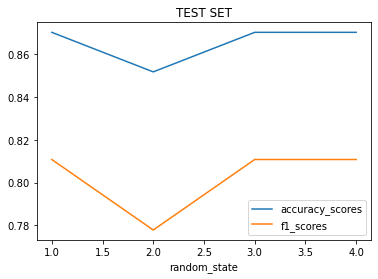

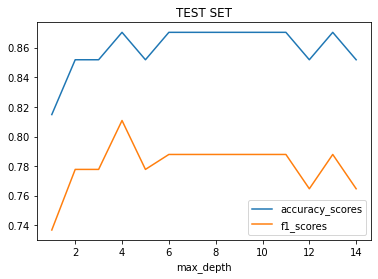

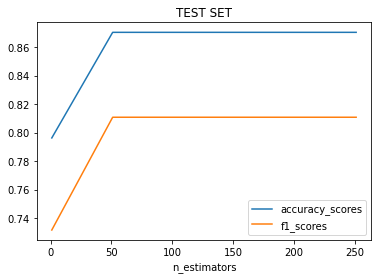

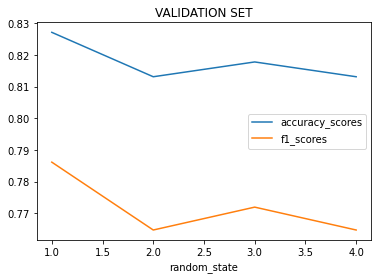

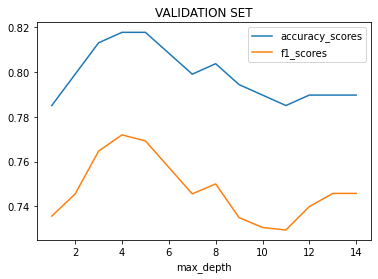

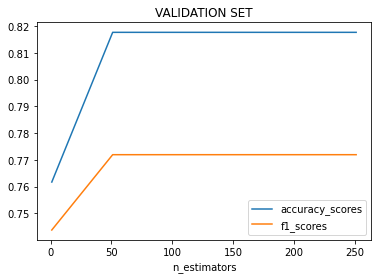

In [1260]:
test_model(X, y)

# Model 

In [1261]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
test_model = RandomForestClassifier()

In [1273]:
n_estimators = list(range(10,110,10))
max_features = ['auto', 'sqrt']
max_depth = [2,4,6]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [1274]:
    hyperparam = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

In [1275]:
rf_Grid = GridSearchCV(estimator = model, param_grid = hyperparam, cv = 3, verbose = 2, n_jobs = 4)

In [1277]:
rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   34.4s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed:  1.6min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=4, max_features='sqrt',
                                              random_state=1),
             n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             verbose=2)

In [1279]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 90}

In [1312]:
model = RandomForestClassifier(bootstrap= False,
                               max_depth= 4,
                               max_features= 'sqrt',
                               min_samples_leaf= 4,
                               min_samples_split= 5,
                               n_estimators= 120, 
                               random_state=3)

model.fit(X_train, y_train)
predictions_ytest = model.predict(X_test)
predictions_ypredict = model.predict(X_predict)

In [1313]:
accuracy_score(predictions_ytest, y_test)

0.8283582089552238

In [1314]:
f1_score(predictions_ytest, y_test)

0.7788461538461539

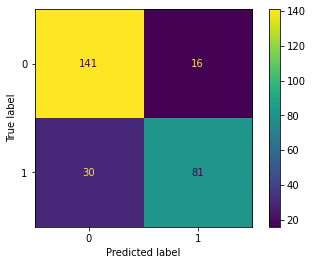

In [1315]:
plot_confusion_matrix(model, X_test, y_test )

In [1285]:
checkdf = y_test.reset_index().rename(columns={'Survived':'y_test', 'index':'PassengerId'})
checkdf['predictions_ytest'] = predictions_ytest
checkdf = pd.merge(checkdf, train_data, on = 'PassengerId', how = 'left')
checkdf['check'] = checkdf['y_test'] - checkdf['predictions_ytest']
checkdf.loc[checkdf['check'] != 0].groupby(by=['Sex', 'check']).mean()

PassengerId  y_test  predictions_ytest  Survived    Pclass  \
Sex    check                                                               
female -1      390.142857     0.0                1.0  1.000000  1.714286   
        1      383.600000     1.0                0.0  0.666667  2.133333   
male   -1      455.700000     0.0                1.0  0.000000  2.600000   
        1      466.055556     1.0                0.0  0.222222  2.500000   

                    Age     SibSp     Parch       Fare  Fare_range  \
Sex    check                                                         
female -1     25.142857  0.571429  0.571429  64.810714    2.142857   
        1     23.666667  0.933333  0.933333  45.501387    1.266667   
male   -1     35.400000  0.400000  0.000000  15.683330    0.200000   
        1     34.125000  0.055556  0.333333  19.820144    0.444444   

              Title_Class  N.Relatives   Company  
Sex    check                                      
female -1       10.142857     1.142857  1.428571  
        1       10.333333     1.866667  2.333333  
male   -1       11.200000     0.400000  1.100000  
        1       11.555556     0.388889  1.222222

In [1290]:
submission = pd.DataFrame(data = list(zip(test_data['PassengerId'], predictions_ypredict)), columns = {'PassengerId', 'Survived'})

In [1293]:
submission.to_csv('my_submission.csv', index = False)